In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [2]:

def load_data(file_path):
    sentences = []
    labels = []
    sentence = []
    label = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split()
                if len(parts) == 2:
                    word, tag = parts
                    sentence.append(word)
                    label.append(tag)
                else:
                    # Mengabaikan baris yang tidak memiliki tepat dua elemen
                    continue
            else:
                if sentence and label:
                    sentences.append(sentence)
                    labels.append(label)
                sentence = []
                label = []

    # Untuk menangani kalimat terakhir jika tidak diakhiri oleh baris kosong
    if sentence and label:
        sentences.append(sentence)
        labels.append(label)

    return sentences, labels



train_sentences, train_labels = load_data('./dataset/train_preprocess.txt')
val_sentences, val_labels = load_data('./dataset/valid_preprocess.txt')
test_sentences, test_labels = load_data('./dataset/test_preprocess.txt')



In [3]:
print('sampel data training:', train_sentences[0])
print('sampel label training:', train_labels[0])

sampel data training: ['kepala', 'dinas', 'tata', 'kota', 'manado', 'amos', 'kenda', 'menyatakan', 'tidak', 'tahu', '-', 'menahu', 'soal', 'pencabutan', 'baliho', '.', 'ia', 'enggan', 'berkomentar', 'banyak', 'karena', 'merasa', 'bukan', 'kewenangannya', '.']
sampel label training: ['O', 'O', 'O', 'O', 'B-PLC', 'B-PPL', 'I-PPL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [4]:
print('jumlah data training :', len(train_sentences))
print('jumlah data validasi :', len(val_sentences))

jumlah data training : 6720
jumlah data validasi : 840


In [5]:

# Tokenisasi kata dan label
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences + val_sentences + test_sentences)
word_index = tokenizer.word_index

max_len = max(len(sentence) for sentence in train_sentences + val_sentences + test_sentences)
num_words = len(word_index) + 1

X_train = pad_sequences(tokenizer.texts_to_sequences(train_sentences), maxlen=max_len, padding='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(val_sentences), maxlen=max_len, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_sentences), maxlen=max_len, padding='post')



In [21]:
# save tokenizer
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [6]:
word_index

{',': 1,
 '.': 2,
 'yang': 3,
 'di': 4,
 'dan': 5,
 '"': 6,
 '(': 7,
 ')': 8,
 'ini': 9,
 'dari': 10,
 'dengan': 11,
 'untuk': 12,
 'pada': 13,
 'dalam': 14,
 'itu': 15,
 'akan': 16,
 'tidak': 17,
 '-': 18,
 'indonesia': 19,
 'juga': 20,
 'tahun': 21,
 'ada': 22,
 'tersebut': 23,
 'ke': 24,
 'sebagai': 25,
 'jakarta': 26,
 'adalah': 27,
 'kata': 28,
 'telah': 29,
 'partai': 30,
 'oleh': 31,
 'saat': 32,
 'bisa': 33,
 'menjadi': 34,
 'presiden': 35,
 'sudah': 36,
 'mengatakan': 37,
 'seperti': 38,
 'mereka': 39,
 'karena': 40,
 'dia': 41,
 'bahwa': 42,
 'atau': 43,
 'saya': 44,
 'lebih': 45,
 'hari': 46,
 'nya': 47,
 'kami': 48,
 'para': 49,
 'kepada': 50,
 'baru': 51,
 'menurut': 52,
 'ketua': 53,
 '/': 54,
 'negara': 55,
 'orang': 56,
 'dua': 57,
 'setelah': 58,
 'masih': 59,
 'tak': 60,
 'namun': 61,
 'banyak': 62,
 'lalu': 63,
 'merupakan': 64,
 'the': 65,
 'hanya': 66,
 'belum': 67,
 'kita': 68,
 'kota': 69,
 'menteri': 70,
 'lain': 71,
 'beberapa': 72,
 ':': 73,
 'ujar': 74,
 'pks

In [7]:
print(max_len)

110


In [8]:
# Membuat indeks label
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels + val_labels + test_labels)
label_index = label_tokenizer.word_index
print(word_index)
num_labels = len(label_index) + 1

y_train = pad_sequences(label_tokenizer.texts_to_sequences(train_labels), maxlen=max_len, padding='post')
y_val = pad_sequences(label_tokenizer.texts_to_sequences(val_labels), maxlen=max_len, padding='post')
y_test = pad_sequences(label_tokenizer.texts_to_sequences(test_labels), maxlen=max_len, padding='post')

y_train = to_categorical(y_train, num_labels)
y_val = to_categorical(y_val, num_labels)
y_test = to_categorical(y_test, num_labels)

{',': 1, '.': 2, 'yang': 3, 'di': 4, 'dan': 5, '"': 6, '(': 7, ')': 8, 'ini': 9, 'dari': 10, 'dengan': 11, 'untuk': 12, 'pada': 13, 'dalam': 14, 'itu': 15, 'akan': 16, 'tidak': 17, '-': 18, 'indonesia': 19, 'juga': 20, 'tahun': 21, 'ada': 22, 'tersebut': 23, 'ke': 24, 'sebagai': 25, 'jakarta': 26, 'adalah': 27, 'kata': 28, 'telah': 29, 'partai': 30, 'oleh': 31, 'saat': 32, 'bisa': 33, 'menjadi': 34, 'presiden': 35, 'sudah': 36, 'mengatakan': 37, 'seperti': 38, 'mereka': 39, 'karena': 40, 'dia': 41, 'bahwa': 42, 'atau': 43, 'saya': 44, 'lebih': 45, 'hari': 46, 'nya': 47, 'kami': 48, 'para': 49, 'kepada': 50, 'baru': 51, 'menurut': 52, 'ketua': 53, '/': 54, 'negara': 55, 'orang': 56, 'dua': 57, 'setelah': 58, 'masih': 59, 'tak': 60, 'namun': 61, 'banyak': 62, 'lalu': 63, 'merupakan': 64, 'the': 65, 'hanya': 66, 'belum': 67, 'kita': 68, 'kota': 69, 'menteri': 70, 'lain': 71, 'beberapa': 72, ':': 73, 'ujar': 74, 'pks': 75, 'harus': 76, 'ia': 77, 'selama': 78, 'tapi': 79, 'sebuah': 80, 'hin

In [9]:
# Mengambil label unik dari train_labels
unique_labels = set(label for sublist in train_labels for label in sublist)

# Menampilkan label-label unik
print("Label Unik:")
print(unique_labels)

# Menghitung jumlah label unik
num_labels = len(unique_labels)
print("Jumlah Label Unik:", num_labels)

# Mengambil label unik dari train_labels
unique_labels = set(label for sublist in val_labels for label in sublist)

# Menampilkan label-label unik
print("Label Unik:")
print(unique_labels)


Label Unik:
{'B-EVT', 'B-PLC', 'B-IND', 'I-FNB', 'I-PLC', 'B-PPL', 'I-PPL', 'O', 'I-EVT', 'I-IND', 'B-FNB'}
Jumlah Label Unik: 11
Label Unik:
{'B-PLC', 'B-EVT', 'B-IND', 'I-FNB', 'I-PLC', 'B-PPL', 'I-PPL', 'O', 'I-EVT', 'I-IND', 'B-FNB'}


## Penjelasan Label

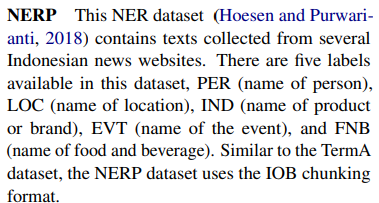
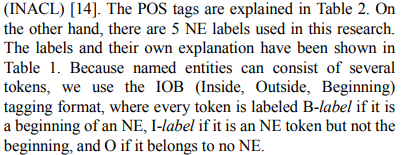


In [10]:
X_train.shape


(6720, 110)

In [11]:
from gensim.models import Word2Vec

# Melatih Word2Vec pada korpus teks
all_sentences = train_sentences + val_sentences + test_sentences
word2vec_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=5, workers=4)

# Membuat matriks embedding
embedding_dim = 100
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [12]:



model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 100,  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_len,), trainable=False),
    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_labels + 1, activation='softmax'))
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 110, 100)          │  2,128,500 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d (Conv1D)                 │ (None, 110, 128)          │     38,528 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional (Bidirectional)   │ (None, 110, 128)          │     98,816 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed                │ (None, 110, 16)           │      2,064 │
│ (TimeDistributed)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_1              │ (None, 110, 16)           │          0 │
│ (TimeDistributed)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_2              │ (None, 110, 12)           │        204 │
│ (TimeDistributed)               │                           │            │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,268,112 (8.65 MB)

 Trainable params: 2,268,112 (8.65 MB)

 Non-trainable params: 0 (0.00 B)

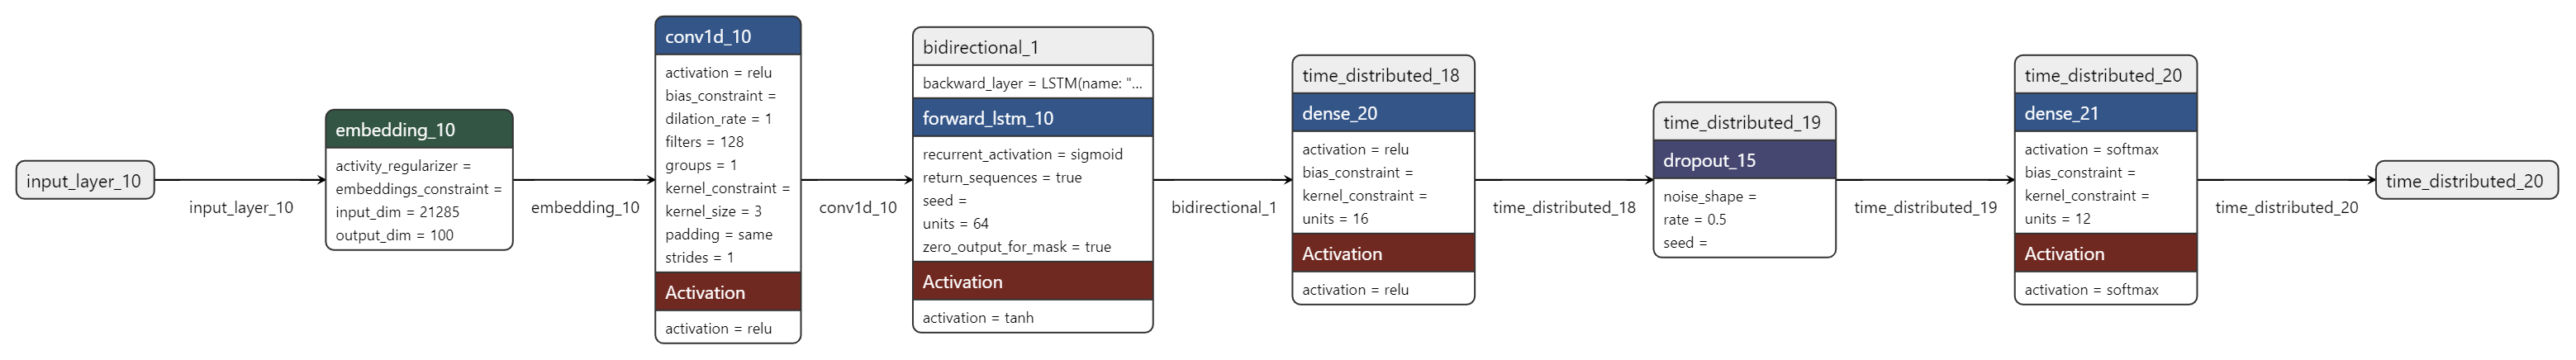

In [13]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 75s 222ms/step - accuracy: 0.8394 - loss: 0.6255 - val_accuracy: 0.9704 - val_loss: 0.1036
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 43s 207ms/step - accuracy: 0.9559 - loss: 0.1422 - val_accuracy: 0.9732 - val_loss: 0.0898
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 43s 207ms/step - accuracy: 0.9623 - loss: 0.1119 - val_accuracy: 0.9755 - val_loss: 0.0864
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 46s 219ms/step - accuracy: 0.9625 - loss: 0.1043 - val_accuracy: 0.9782 - val_loss: 0.0837
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 45s 216ms/step - accuracy: 0.9643 - loss: 0.0943 - val_accuracy: 0.9797 - val_loss: 0.0826
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 44s 207ms/step - accuracy: 0.9656 - loss: 0.0901 - val_accuracy: 0.9806 - val_loss: 0.0808
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - accuracy: 0.9675 - loss: 0.0828 - val_accuracy: 0.9832 - val_loss: 0.0758
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 46s 220ms/step - accuracy: 0.9702 - loss: 0

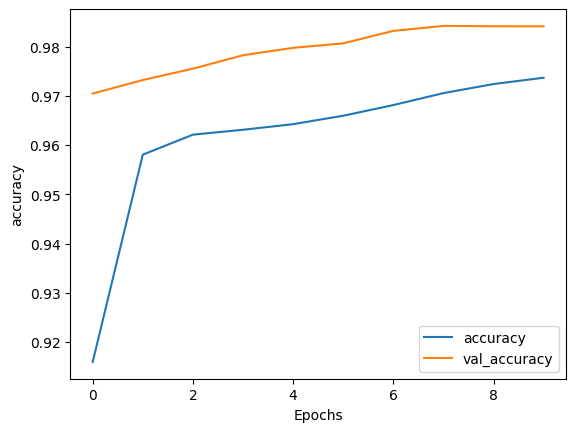

In [14]:
import matplotlib.pyplot as plt

# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

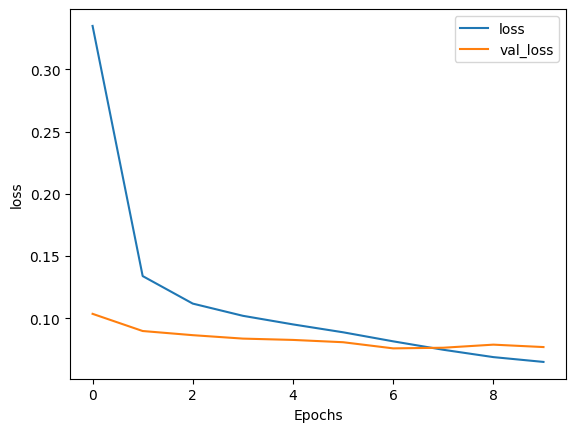

In [15]:
# losss
plot_graphs(history, "loss")

In [16]:
import numpy as np
from sklearn.metrics import classification_report

# Melakukan prediksi pada data validasi
y_pred = model.predict(X_val)

# Mendapatkan indeks label dengan nilai tertinggi
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = np.argmax(y_val, axis=-1)

# Mengubah prediksi dan label sebenarnya ke dalam format yang cocok untuk classification_report
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

# Menghapus padding dari prediksi dan label sebenarnya
mask = np.where(y_true_flat != 0)  # Mengasumsikan label '0' adalah padding
y_pred_flat = y_pred_flat[mask]
y_true_flat = y_true_flat[mask]

# Menampilkan laporan klasifikasi
report = classification_report(y_true_flat, y_pred_flat)
print(report)


27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step
              precision    recall  f1-score   support

           1       0.96      0.98      0.97     16696
           2       0.88      0.75      0.81       640
           3       0.82      0.73      0.77       517
           4       0.52      0.67      0.59       369
           5       0.88      0.65      0.75       386
           6       0.45      0.70      0.55       286
           7       0.54      0.53      0.54       225
           8       0.00      0.00      0.00       174
           9       0.00      0.00      0.00       127
          10       0.00      0.00      0.00        87
          11       0.00      0.00      0.00        47

    accuracy                           0.92     19554
   macro avg       0.46      0.46      0.45     19554
weighted avg       0.91      0.92      0.92     19554



c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [17]:
print(train_sentences)
print(len(train_labels[0]))


[['kepala', 'dinas', 'tata', 'kota', 'manado', 'amos', 'kenda', 'menyatakan', 'tidak', 'tahu', '-', 'menahu', 'soal', 'pencabutan', 'baliho', '.', 'ia', 'enggan', 'berkomentar', 'banyak', 'karena', 'merasa', 'bukan', 'kewenangannya', '.'], ['di', 'antara', 'mereka', 'itu', 'mengaku', 'tidak', 'tersinggung', 'dengan', 'ucapan', 'ahok', '...'], ['pasukan', 'pengibar', 'bendera', 'membawa', 'kereta', 'kencana', 'usai', 'latihan', 'upacara', 'pengibaran', 'bendera', 'jelang', 'perayaan', 'hut', 'kemerdekaan', 'ri', 'di', 'monas', ',', 'gambr', ',', 'jakarta', 'pusat', ',', 'minggu', '(', '13', '/', '8', ')', '.'], ['ketika', 'ditanyai', 'mengenai', 'kemungkinan', 'organisasi', 's.', 'h.', 'i.', 'e.', 'l.', 'd', 'menyadari', 'kehadiran', 'para', 'vigilante', '(', 'penegak', 'hukum', 'non-resmi', ')', 'dari', 'hells', 'kitchen', '--', 'sebuah', 'tempat', 'betulan', 'di', 'kota', 'new', 'york', 'yang', 'menjadi', 'set', 'lokasi', 'serial', 'daredevil', ',', 'jessica', 'jones', ',', 'the', 'pu

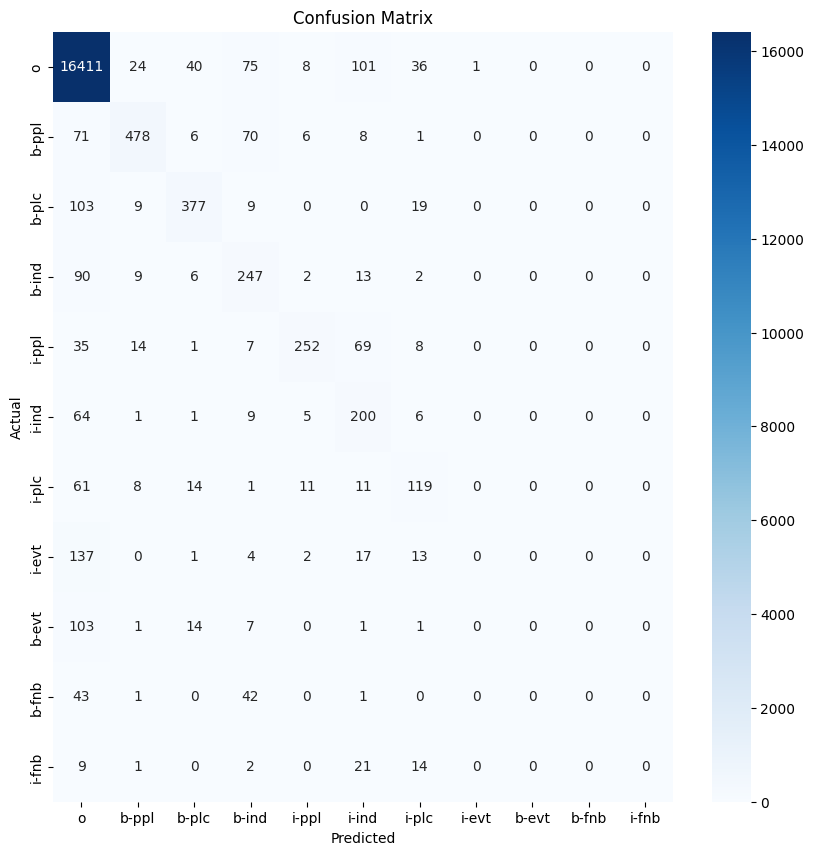

In [18]:
# confussion matrix with sns
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Menghitung matriks kebingungan
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Membuat plot matriks kebingungan
plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_index.keys(), yticklabels=label_index.keys(), cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

In [19]:
# Kalimat baru untuk pengujian
new_sentence = "joko widodo sedang berada di depan istana presiden untuk bertemu dengan komisi"

# Tokenisasi teks

# Define the index_to_label dictionary
index_to_label = {v: k for k, v in label_index.items()}

sample_seq = tokenizer.texts_to_sequences([new_sentence])
sample_padded = pad_sequences(sample_seq, maxlen=max_len, truncating="post", padding="post")

# Lakukan prediksi dengan model
y_pred = model.predict(sample_padded)

# Mendapatkan indeks label dengan nilai tertinggi untuk setiap token
predicted_labels = [np.argmax(pred) for pred in y_pred[0]]

# Mengonversi indeks label menjadi label teks menggunakan inverse mapping
predicted_labels = [index_to_label.get(idx, '<PAD>') for idx in predicted_labels]

# Menampilkan hasil prediksi
print("Kalimat:", new_sentence)
print("Prediksi NER:", predicted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Kalimat: joko widodo sedang berada di depan istana presiden untuk bertemu dengan komisi
Prediksi NER: ['b-ppl', 'i-ppl', 'o', 'o', 'o', 'o', 'b-plc', 'o', 'o', 'o', 'o', 'o', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PA

In [25]:
def load_news_sentences(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        news_sentences = [line.strip() for line in file if line.strip()]
    return news_sentences

# Contoh penggunaan
news_file_path = './dataset/testing-berita.txt'
news_sentences = load_news_sentences(news_file_path)


In [26]:
# Tokenisasi dan padding
sample_sequences = tokenizer.texts_to_sequences(news_sentences)
sample_padded = pad_sequences(sample_sequences, maxlen=max_len, padding='post')

In [27]:
# Prediksi dengan model
y_pred = model.predict(sample_padded)

# Define the index_to_label dictionary
index_to_label = {v: k for k, v in label_index.items()}

# Mendapatkan indeks label dengan nilai tertinggi untuk setiap token
predicted_labels = [[np.argmax(pred) for pred in sentence] for sentence in y_pred]

# Konversi indeks label ke label teks
predicted_labels = [[index_to_label.get(idx, '<PAD>') for idx in sentence] for sentence in predicted_labels]

# Menampilkan hasil prediksi
for i, sentence in enumerate(news_sentences):
    print("Kalimat:", sentence)
    print("Prediksi NER:", predicted_labels[i])
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Kalimat: JAKARTA, KOMPAS.com - Presiden Joko Widodo (Jokowi) mengatakan dirinya terkejut dan sedih atas peristiwa penembakan yang menimpa mantan Presiden Amerika Serikat (AS) Donald Trump.
Prediksi NER: ['b-plc', 'b-ind', 'i-ind', 'o', 'b-ppl', 'i-ppl', 'i-ppl', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'b-plc', 'i-plc', 'i-plc', 'b-ppl', 'i-ppl', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>',